# Guide to Wonky


In [3]:
%matplotlib inline
import wonky

## Choose a chemical reaction system and initial conditions

In this example the CRN is on a square lattice. It is easy to plug in different graphs

In principle any reaction network can be simulated although I have only tested simply reaction networks

In [11]:
rsys =  wonky.reaction.reaction_system([wonky.reaction("A", "A+A", 0.5),
                                        wonky.reaction("A", "0", 0.5)])
net = wonky.crn(rsys, (9,2), ICs=[1])

## Sample from the CRN and view statistics

Waiting times are not handled in this simple example but it is easy to fold time onto a log scale for example and use conditional stat writing

,0,1,2,3,4,5,6,7,8
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,2.0,4.0,8.0,16.0,32.0,64.0,128.0,256.0
2,1.0,3.0,9.0,27.0,81.0,243.0,729.0,2187.0,6561.0
3,1.0,4.0,16.0,64.0,256.0,1024.0,4096.0,16384.0,65536.0
4,1.0,3.0,9.0,27.0,81.0,243.0,729.0,2187.0,6561.0
5,1.0,4.0,16.0,64.0,256.0,1024.0,4096.0,16384.0,65536.0
6,1.0,5.0,25.0,125.0,625.0,3125.0,15625.0,78125.0,390625.0
7,1.0,4.0,16.0,64.0,256.0,1024.0,4096.0,16384.0,65536.0
8,1.0,5.0,25.0,125.0,625.0,3125.0,15625.0,78125.0,390625.0
9,1.0,4.0,16.0,64.0,256.0,1024.0,4096.0,16384.0,65536.0


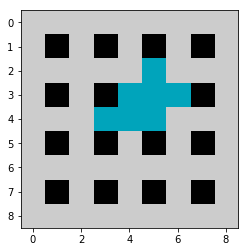

In [13]:
net.sample(display=True,params={"name":"./sample_data/exp/01"})
net.stats.observable(obs=0)

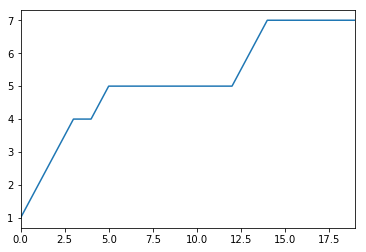

In [14]:
net.stats.observable(obs=1)[1].plot()

## Experiments

In [15]:
params = {
    #in practice N would be a different type of parameter i.e. we would sample(N, params)
    "N" : range(10),
    "P" : ["A", "B", "C"],
    "A" : [1]
}
wonky.utils.get_paramter_space(params)

,A,N,P,name
0,1,0,A,00
1,1,0,B,01
2,1,0,C,02
3,1,1,A,03
4,1,1,B,04
5,1,1,C,05
6,1,2,A,06
7,1,2,B,07
8,1,2,C,08
9,1,3,A,09


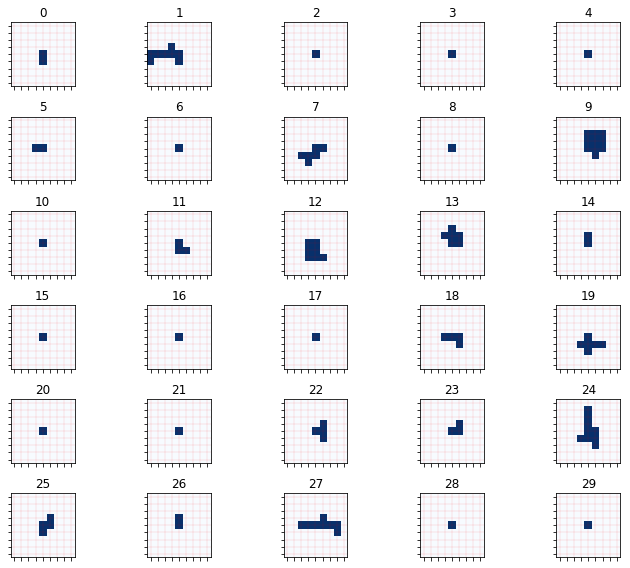

In [16]:
params = {
    #for this sample, range must be serializable
    "N" : list(range(10)),
    "P" : ["A", "B", "C"],
    "A" : [1]
}
images = list(net.run_experiment(params,yield_trace=True))
wonky.plotting.plot_many(images, (6,5)) 

### Compile all chunks

In [31]:
my_data  = wonky.utils.compile_statistics(params=params)
my_data#[::5]

,A,N,P,index,0,1,2,3,4,5,6,7,8
name,,,,,,,,,,,,,
00,1,0,A,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
00,1,0,A,1,1.0,2.0,4.0,8.0,16.0,32.0,64.0,128.0,256.0
00,1,0,A,2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
00,1,0,A,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00,1,0,A,4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00,1,0,A,5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00,1,0,A,6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00,1,0,A,7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00,1,0,A,8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
import numpy as np
np.load("./sample_data/exp/00.npy")#[0][1][1]

array([[[[  1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
            1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.],
         [  1.,   2.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
         [  1.,   4.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
         [  1.,   8.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
         [  1.,  16.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
         [  1.,  32.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
         [  1.,  64.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
            0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
         [  1

In [36]:
my_data[my_data.P == "C"].groupby(["index"]).mean()

,A,N,0,1,2,3,4,5,6,7,8
index,,,,,,,,,,,
0,1.0,4.5,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,4.5,1.0,1.0,2.0,4.0,8.0,16.0,32.0,64.0,128.0
2,1.0,4.5,1.0,0.9,2.1,5.7,16.5,48.9,146.1,437.7,1312.5
3,1.0,4.5,1.0,0.6,1.2,2.4,4.8,9.6,19.2,38.4,76.8
4,1.0,4.5,1.0,0.7,1.9,5.5,16.3,48.7,145.9,437.5,1312.3
5,1.0,4.5,1.0,0.6,1.2,2.4,4.8,9.6,19.2,38.4,76.8
6,1.0,4.5,1.0,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3
7,1.0,4.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,4.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
